The goal is to replicate the LSMC method implemented [here](https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf) which is considered to be an industry standard for pricing American (put) options. 

Other useful sources: 
- [Youtube lecture series](https://www.youtube.com/watch?v=4KAqgK_85UI&list=PLJ9XZsVSloaQ3bkTpJvWHEEjWiW27F8Zx&index=29) (1-3)

- Tools for Computational Finance by R. U. Seydel



In [29]:
# Libraries
import numpy as np
import pandas as pd
from scipy.stats import norm

Starting example where we have fixed paths (see paper, link above):
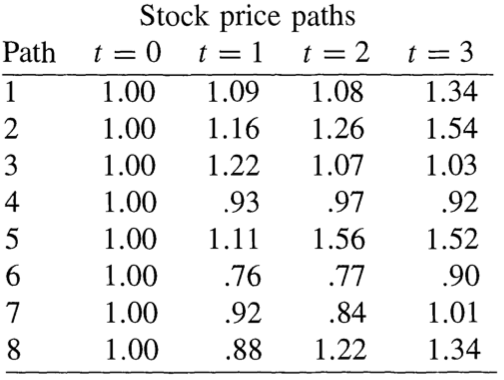

In [30]:
K = 1.10
r = 0.06
df = np.exp(-r) # one step df; t=1
print(f"Discounting factor: ", df)

# They simulated 8 paths, under r-n measure and put them in the table 
# -> So we need to copy that table, to keep it the same -> hard-code it.
S = np.array([[1.00, 1.09, 1.08, 1.34],
              [1.00, 1.16, 1.26, 1.54],
              [1.00, 1.22, 1.07, 1.03],
              [1.00, 0.93, 0.97, 0.92],
              [1.00, 1.11, 1.56, 1.52],
              [1.00, 0.76, 0.77, 0.90],
              [1.00, 0.92, 0.84, 1.01],
              [1.00, 0.88, 1.22, 1.34]
            ])
n_paths = S.shape[0]
#print(df_stock_paths)

# exact price - Black-Scholes formula; from ftcs_bs_put
def bs_put_price(S0, K, r, sigma, T):
    d1 = ( np.log(S0/K) + (r + 0.5*sigma**2) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    bs_put = -1 * norm.cdf(-d1)*S0 + norm.cdf(-d2)*K*np.exp(-r*T)
    return bs_put

Discounting factor:  0.9417645335842487


In [31]:
# TIME = 3
# Payoff at maturity t=3
h3 = np.maximum(K - S[:, 3], 0.0) # put payoff

# Table: Cashflow at time 3
paths = np.arange(1, n_paths + 1)
df_cash3 = pd.DataFrame({"Path": paths,
                        "t = 1": ["-"] * n_paths,   
                        "t = 2": ["-"] * n_paths,
                        "t = 3": ["" for _ in range(n_paths)],
                        }).set_index("Path")
# Fill in the values
for i in range(n_paths):
    payoff = h3[i]
    df_cash3.loc[i+1, "t = 3"] = f"{payoff:.5f}"

# Table 1: CF at t=3
print("Cashflow at time 3")
print(df_cash3)

Cashflow at time 3
     t = 1 t = 2    t = 3
Path                     
1        -     -  0.00000
2        -     -  0.00000
3        -     -  0.07000
4        -     -  0.18000
5        -     -  0.00000
6        -     -  0.20000
7        -     -  0.09000
8        -     -  0.00000


In [48]:
# TIME = 2

h2 = np.maximum(K - S[:, 2], 0.0) # put payoff
# Are we In-the-Money? ie h2(i) = max(K - S(i, 2), 0) if h2(i) > 0 -> immediate exercise 
itm2_idx = np.where(h2 > 0)[0] # indeces of those non-zero payoffs

# Continuation from t=3 to t=2
Y3_disc = df * h3 # response value in regression; 

# Matrix for regression
S2_itm = S[itm2_idx, 2]
# Basis functions: 1, x, x^2 - as in paper
X2 = np.vstack([np.ones_like(S2_itm), 
                S2_itm, 
                S2_itm**2
                ]).T  # regression matrix X, col2
#print(X2)
Y2 = Y3_disc[itm2_idx] # response value in regression; discounted h3

# Estimate regression coefficients betas b = [a0, b1, b2]
beta2, *_ = np.linalg.lstsq(X2, Y2)
#print(f"beta2: ", beta2)
print("Least squares formula at time 2:")
print(f"E[Y|X] = {beta2[0]:.5f} + {beta2[1]:.5f}.x + {beta2[2]:.5f}.x^2")

V2 = np.zeros(n_paths) # allocate V2; 
for i in range(n_paths):
    if i in itm2_idx:
        s2 = S[i, 2]
        cont_val = beta2[0] + beta2[1]*s2 + beta2[2]*(s2**2)
        if h2[i] >= cont_val:
            V2[i] = h2[i]            # exercise at t=2
        else:
            V2[i] = df * h3[i]       # continue -> discounted h3
    else:
        V2[i] = df * h3[i]           # out‐of‐money at t=2 -> continue

actual_cf = np.zeros(n_paths)
for i in range(n_paths):
    if i in itm2_idx:
        s2 = S[i, 2]
        cont_val = beta2[0] + beta2[1]*s2 + beta2[2]*(s2**2)
        if h2[i] >= cont_val:
            actual_cf[i] = h2[i]
        else:
            actual_cf[i] = h3[i]
    else:
        actual_cf[i] = h3[i]

# -----------------------------
# Table 2: Regression at time 2
# -----------------------------
"""
Y - corresponding discounted cash flows received at time 3 = Y3_disc; if the put is not exercised at time 2
X - stock prices at time 2
"""
# DataFrame with blanks
df_reg2 = pd.DataFrame({
    "Path": np.arange(1, n_paths + 1),   
    "Y": ["-" for _ in range(n_paths)], # fill empty rows
    "X": ["-" for _ in range(n_paths)]
}).set_index("Path")
# Fill in those in‐the‐money rows
for i in itm2_idx:
    df_reg2.at[i+1, "Y"] = f"{h3[i]:.5f} x {df:.5f}"
    df_reg2.at[i+1, "X"] = f"{S[i, 2]:.5f}"
print("\nRegression at time 2")
print(df_reg2)


Least squares formula at time 2:
E[Y|X] = -1.06999 + 2.98341.x + -1.81358.x^2

Regression at time 2
                      Y        X
Path                            
1     0.00000 x 0.94176  1.08000
2                     -        -
3     0.07000 x 0.94176  1.07000
4     0.18000 x 0.94176  0.97000
5                     -        -
6     0.20000 x 0.94176  0.77000
7     0.09000 x 0.94176  0.84000
8                     -        -


In [33]:
# ------------------------------------------------
# Table: Optimal early exercise decision at time 2
# ------------------------------------------------
paths = np.arange(1, n_paths + 1)

df_dec2 = pd.DataFrame({"Path": paths,
                        "Exercise": ["-"] * len(paths),
                        "Continuation": ["-"] * len(paths)
                        }).set_index("Path")

for i in itm2_idx:
    # Immediate payoff if exercise at t=2: h2[i]
    df_dec2.loc[i+1, "Exercise"] = f"{h2[i]:.5f}"
    # Continuation: beta2[0] + beta2[1]*S2 + beta2[2]*S2^2
    s2 = S[i, 2]
    cont2 = beta2[0] + beta2[1]*s2 + beta2[2]*(s2**2)
    df_dec2.loc[i+1, "Continuation"] = f"{cont2:.5f}"

print("Optimal early exercise decision at time 2")
print(df_dec2)

Optimal early exercise decision at time 2
     Exercise Continuation
Path                      
1     0.02000      0.03674
2           -            -
3     0.03000      0.04590
4     0.13000      0.11753
5           -            -
6     0.33000      0.15197
7     0.26000      0.15642
8           -            -


In [34]:
# -----------------------------------
# Table 3: Cash-flow matrix at time 2
# -----------------------------------
paths = np.arange(1, n_paths + 1)
df_cash2 = pd.DataFrame({"Path": paths,
                        "t = 1": ["-"] * 8,   # no exercises at t=1 
                        "t = 2": ["" for _ in range(8)],
                        "t = 3": ["" for _ in range(8)],
                        }).set_index("Path")

# Fill in undiscounted cashflows at t=2 or t=3, path by path:
for i in range(n_paths):
    if i in itm2_idx:
        # continuation estimate at t=2 for path i
        s2 = S[i, 2]
        cont_val = beta2[0] + beta2[1]*s2 + beta2[2]*(s2**2)
        
        # if exercise at t=2:
        if h2[i] >= cont_val:
            df_cash2.loc[i+1, "t = 2"] = f"{h2[i]:5f}"
            df_cash2.loc[i+1, "t = 3"] = f"{0.00:.5f}"
        else:
            # continue, collect h3 at t=3
            df_cash2.loc[i+1, "t = 2"] = f"{0.00:.5f}" # fill 0s
            df_cash2.loc[i+1, "t = 3"] = f"{h3[i]:.5f}"
    else:
        # out of the money at t=2 -> cashflow is 0 at t=2, pay h3 at t=3
        df_cash2.loc[i+1, "t = 2"] = f"{0.00:.5f}"
        df_cash2.loc[i+1, "t = 3"] = f"{h3[i]:.5f}"

# Display the final table
print("Cash‐flow matrix at time 2:")
print(df_cash2)

Cash‐flow matrix at time 2:
     t = 1     t = 2    t = 3
Path                         
1        -   0.00000  0.00000
2        -   0.00000  0.00000
3        -   0.00000  0.07000
4        -  0.130000  0.00000
5        -   0.00000  0.00000
6        -  0.330000  0.00000
7        -  0.260000  0.00000
8        -   0.00000  0.00000


In [35]:
# TIME = 1

# Compute h1 at t=1 and discount V2 back to t=1:
h1 = np.maximum(K - S[:, 1], 0.0)    # immediate payoff at t=1
Y2_disc = V2 * df                   # discounted V2 back to t=1

# Identify which paths are in-the-money at t=1
itm1_idx = np.where(h1 > 0)[0]

# Build the regression matrix at t=1:  Y2_disc vs {1, S1, (S1)^2}
X1 = np.vstack([
    np.ones_like(S[itm1_idx, 1]),   # column of 1’s
    S[itm1_idx, 1],                 # column of S(t=1)
    S[itm1_idx, 1]**2               # column of S(t=1)^2
]).T
Y1 = Y2_disc[itm1_idx]

beta1, *_ = np.linalg.lstsq(X1, Y1)
# beta1 = [beta1[0], beta1[1], beta1[2]]
# beta1 = np.array([2.038, -3.335, 1.356]) - appears as in paper they used 3 d.p.

# -----------------------------
# Table 4: “Regression at time 1”
# -----------------------------
paths = np.arange(1, n_paths + 1)
df_reg1 = pd.DataFrame({
    "Path": paths,
    "Y":    ["-"] * n_paths,
    "X":    ["-"] * n_paths
}).set_index("Path")
#print(f"h2:", h2)
for i in itm1_idx:
    # Y = h2[i] × 0.94176 e.g. “0.13 × 0.94176”
    df_reg1.loc[i+1, "Y"] = f"{actual_cf[i]:.5f} x {df:.5f}"
    # X = S(t=1) at path i
    df_reg1.loc[i+1, "X"] = f"{S[i, 1]:.5f}"

    
print("Least‐squares formula at time 1:")
print(f"E[Y|X] = {beta1[0]:.5f} + {beta1[1]:.5f}.x + {beta1[2]:.5f}.x^2")
    
print("\nRegression at time 1")
print(df_reg1)

Least‐squares formula at time 1:
E[Y|X] = 2.03751 + -3.33544.x + 1.35646.x^2

Regression at time 1
                      Y        X
Path                            
1     0.00000 x 0.94176  1.09000
2                     -        -
3                     -        -
4     0.13000 x 0.94176  0.93000
5                     -        -
6     0.33000 x 0.94176  0.76000
7     0.26000 x 0.94176  0.92000
8     0.00000 x 0.94176  0.88000


In [47]:
# Table 5: “Optimal early exercise decision at time 1”

df_dec1 = pd.DataFrame({
    "Path": paths,
    "Exercise":     ["-" for _ in range(n_paths)],
    "Continuation": ["-" for _ in range(n_paths)]
}).set_index("Path")

for i in itm1_idx:
    # Compute continuation estimate at t=1:
    x1 = S[i, 1]
    cont1 = beta1[0] + beta1[1]*x1 + beta1[2]*(x1**2)
    # Fill “Exercise” = h1[i]  
    df_dec1.loc[i+1, "Exercise"] = f"{h1[i]:.5f}"
    # Fill “Continuation” = cont1 
    df_dec1.loc[i+1, "Continuation"] = f"{cont1:.5f}"
    
print("Optimal early exercise decision at time 1")
print(df_dec1)


Optimal early exercise decision at time 1
     Exercise Continuation
Path                      
1     0.01000      0.01349
2           -            -
3           -            -
4     0.17000      0.10875
5           -            -
6     0.34000      0.28606
7     0.18000      0.11701
8     0.22000      0.15276


In [46]:
# Stopping time

# Stopping means exercise
# Determine stop1 (exercise at t=1) using exact continuation
stop1 = np.zeros(n_paths, dtype=int)
for i in itm1_idx:
    s1 = S[i, 1]
    cont1 = beta1[0] + beta1[1]*s1 + beta1[2]*(s1**2)
    if h1[i] >= cont1:
        stop1[i] = 1

# Determine stop2 (exercise at t=2) for those which did not stop at t=1:
stop2 = np.zeros(n_paths, dtype=int)
for i in itm2_idx:
    if stop1[i] == 0:
        s2 = S[i, 2]
        cont2 = beta2[0] + beta2[1]*s2 + beta2[2]*(s2**2)
        if h2[i] >= cont2:
            stop2[i] = 1

# Determine stop3 (must stop at t=3 if not stopped earlier):
stop3 = np.zeros(n_paths, dtype=int)
for i in range(n_paths):
    if stop1[i] == 0 and stop2[i] == 0 and h3[i] > 0:
        stop3[i] = 1
    else:
        stop3[i] = 0

# Build the DataFrame exactly as in the paper:
paths = np.arange(1, n_paths+1)
df_stop = pd.DataFrame({
    "Path":  paths,
    "t = 1": stop1,
    "t = 2": stop2,
    "t = 3": stop3
}).set_index("Path")

print("Stopping rule")
print(df_stop)


Stopping rule
      t = 1  t = 2  t = 3
Path                     
1         0      0      0
2         0      0      0
3         0      0      1
4         1      0      0
5         0      0      0
6         1      0      0
7         1      0      0
8         1      0      0


In [45]:
# Option cash flow matrix

paths = np.arange(1, n_paths+1) 

# Build a DataFrame with blanks for every (t=1, t=2, t=3) - fill later
df_opt_cf = pd.DataFrame({
    "Path":  paths,
    "t = 1": ["-" for _ in range(n_paths)],
    "t = 2": ["-" for _ in range(n_paths)],
    "t = 3": ["-" for _ in range(n_paths)]
}).set_index("Path")

for i in range(n_paths):
    # If stop1[i]==1, we exercise at t=1
    if stop1[i] == 1:
        df_opt_cf.loc[i+1, "t = 1"] = f"{h1[i]:.5f}"
        df_opt_cf.loc[i+1, "t = 2"] = f"{0.00:.5f}"
        df_opt_cf.loc[i+1, "t = 3"] = f"{0.00:.5f}"
    # Else if stop2[i]==1, we exercise at t=2
    elif stop2[i] == 1:
        df_opt_cf.loc[i+1, "t = 1"] = f"{0.00:.5f}"
        df_opt_cf.loc[i+1, "t = 2"] = f"{h2[i]:.5f}"
        df_opt_cf.loc[i+1, "t = 3"] = f"{0.00:.5f}"
    # Else if stop3[i]==1, we exercise at t=3
    elif stop3[i] == 1:
        df_opt_cf.loc[i+1, "t = 1"] = f"{0.00:.5f}"
        df_opt_cf.loc[i+1, "t = 2"] = f"{0.00:.5f}"
        df_opt_cf.loc[i+1, "t = 3"] = f"{h3[i]:.5f}"
    else:
        # If a path never exercises (all stops zero), pay zero everywhere
        df_opt_cf.loc[i+1, "t = 1"] = f"{0.00:.5f}"
        df_opt_cf.loc[i+1, "t = 2"] = f"{0.00:.5f}"
        df_opt_cf.loc[i+1, "t = 3"] = f"{0.00:.5f}"

print("Option cash flow matrix")
print(df_opt_cf)


Option cash flow matrix
        t = 1    t = 2    t = 3
Path                           
1     0.00000  0.00000  0.00000
2     0.00000  0.00000  0.00000
3     0.00000  0.00000  0.07000
4     0.17000  0.00000  0.00000
5     0.00000  0.00000  0.00000
6     0.34000  0.00000  0.00000
7     0.18000  0.00000  0.00000
8     0.22000  0.00000  0.00000


In [39]:
# Pricing AM-option

discounted_values = np.zeros(n_paths)
# We need to go path-by-path
for i in range(n_paths):
    # Determine at which time t* this i-th path exercises
    if stop1[i] == 1:
        t_star = 1
        cf = h1[i]
    elif stop2[i] == 1:
        t_star = 2
        cf = h2[i]
    elif stop3[i] == 1:
        t_star = 3
        cf = h3[i]
    else:
        # path never exercises, so CF = 0
        t_star = None
        cf = 0.0

    # Discount that single cash flow back to time zero
    if t_star is not None:
        discounted_values[i] = cf * np.exp(-r * t_star)
    else:
        discounted_values[i] = 0.0


""" From the paper: option can now be valued by discounting each cash
flow in the option cash flow matrix back to time zero, and averaging over all paths.
For EU: value of .0564 for the European put obtained 
        by discounting back the cash flows at time 3 from the first cash flow matrix.
            - So, also the EU-put is valued a some kind of of MC-average? So, no closed form BS price.
"""
# American‐put price is avg of discounted values
american_put_price = np.mean(discounted_values)
# EU-put
# path-by-path: h3[i] = max(K - S(i, 3), 0)
# PV = e^{-3*r} 1/n sum(h3[i])
# Discount factor from t=3 back to 0:
df3 = np.exp(-r * 3)
# Compute the European‐put price as the average of (df3 * h3):
european_put_price1 = np.mean(h3 * df3) # matches the paper 0.0564

print(f"American put price = {american_put_price:.5f}")
print(f"European put price = {european_put_price1:.5f}")
print(f"Early exercise premium = {american_put_price - european_put_price1:.5f}")

American put price = 0.11443
European put price = 0.05638
Early exercise premium = 0.05805


Now, instead of considering the fixed paths, we will generate the paths by Monte Carlo under the standard Geometric Brownian motion, $$\mathrm{d}S_t = \mu S_t \mathrm{d}t + \sigma S_t \mathrm{d}W_t,$$ where $S_t$ - stock price, $W_t$ - standard Brownian motion. 

First, we will consider the exact price given by Black-Scholes model and simulate the paths under GBM.

Second, we will develop LSMC-pricer function using the Laguerre polynomials as implemented in the paper.

In [49]:
# Exact price - Black-Scholes formula
def bs_put_price(S0, K, r, sigma, T):
    d1 = ( np.log(S0/K) + (r + 0.5*sigma**2) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    bs_put = -1 * norm.cdf(-d1)*S0 + norm.cdf(-d2)*K*np.exp(-r*T)
    return bs_put

In [50]:
# MC paths generator with antithetic sampling
def simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths):
    """ Antithetic: We input 50,000 paths and we get 100,000 paths """
    np.random.seed(1) 
    dt = T / n_steps

    # Generate randoms for half of n_paths
    Z = np.random.randn(n_paths, n_steps)
    
    # Create vector of paths and antithetic paths
    Z_all = np.vstack([Z, -Z])  
    
    # Initialize paths
    n_total = 2 * n_paths
    S = np.zeros((n_total, n_steps + 1))
    S[:, 0] = S0
    
    # Simulate paths
    for t in range(n_steps):
        S[:, t+1] = S[:, t] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z_all[:, t])
    
    return S


As considered in the paper, we define the Laguerre polynomials which we will use as basis functions for the linear regression.

In [51]:
def laguerre_polynomials(x, K):
    """ Calculate first three Laguerre polynomials
    x_scaled as x / K - to account for moneyness """
    # Scale x 
    x_scaled = x / K  # Normalize by strike price 
    
    # Calculate e^(-x/2) 
    exp_term = np.exp(-x_scaled/2)
    
    # Laguerre polynomials
    L0 = exp_term
    L1 = exp_term * (1 - x_scaled)
    L2 = exp_term * (1 - 2*x_scaled + x_scaled**2/2)
    
    return L0, L1, L2

Discuss the plan of attack developing LSMC-pricer, what is the intuition, how can we visualise this?

In [52]:
def lsmc_american_put(S, K, r, T, n_steps):
    """ Least Squares Monte Carlo for American Put Option
    Similar approach as in Q1, but now we don't view it as tree/lattice 
    but a whole random path at different times t; ie more cts
    - going backwards in time, ie from terminal time (known payoff) to t=0.
    - we use regression to estimate the continuation value 
    - early exercise decision
    """
    n_paths = S.shape[0]
    dt = T / n_steps
    df = np.exp(-r * dt)
    
    # Initialize cash flow matrix
    cash_flows = np.zeros((n_paths, n_steps + 1))
    
    # Terminal payoff
    cash_flows[:, -1] = np.maximum(K - S[:, -1], 0)
    
    # Backward induction
    for t in range(n_steps - 1, 0, -1):
        # Current payoff if exercised
        payoff = np.maximum(K - S[:, t], 0)
        
        # Find in-the-money paths
        itm = payoff > 0 # will use as index for tracking
        
        if np.sum(itm) > 0:
            # Get stock prices for ITM paths
            X = S[itm, t]
            
            # Calculate basis functions according to paper
            L0, L1, L2 = laguerre_polynomials(X, K)
            
            # Data matrix: constant (intercept) + 3 Laguerre polynomials
            A = np.column_stack([np.ones_like(X), L0, L1, L2])
            
            # Calculate discounted future cash flows Y - response variable
                # Continuation value we are want to estimate
            Y = np.zeros(n_paths) #
            for s in range(t+1, n_steps+1):
                Y += cash_flows[:, s] * df**(s-t) 
            Y = Y[itm]
            
            # Regression to estimate continuation value
            beta = np.linalg.lstsq(A, Y)[0] # prediction
            #print(beta)
            cont_value = A @ beta
            #print(cont_value)
            
            # Exercise decision: exercise if immediate payoff >= continuation value
            exercise = payoff[itm] >= cont_value
            
            # Update cash flows
            itm_indices = np.where(itm)[0]
            for i, should_exercise in enumerate(exercise):
                idx = itm_indices[i]
                if should_exercise:
                    cash_flows[idx, t] = payoff[idx]
                    # Zero out future cash flows
                    cash_flows[idx, t+1:] = 0
    
    # for each path, find time when of exercise and discout it back to t=0
    option_values = np.zeros(n_paths)
    for i in range(n_paths):
        # Find all times when this option has positive cf
        exercise_times = np.where(cash_flows[i, :] > 0)[0]

        if len(exercise_times) > 0:
            t_exercise = exercise_times[0] # per path 1 exercise
            option_values[i] = cash_flows[i, t_exercise] * df**t_exercise # dicsouting it to t=0
    
    # Return mean value (since path dependent) and standard error
    mean_value = np.mean(option_values) # option PV 
    std_error = np.std(option_values) / np.sqrt(n_paths)
    
    return mean_value, std_error


Combining the above, we are able to replicate the Table 1 in the paper.

In [53]:
def replicate_table1_row(S0, sigma, T, K=40, r=0.06, n_paths=50000, n_steps_per_year=50): # exercisable 50x per year = n_steps
    """ Replicate one row of Table 1 
    Goal is to replicate the table row-by-row and compute the required cols """
    np.random.seed(1) # We fix the seed for each row, so its the same
    
    # Number of time steps
    n_steps = int(T * n_steps_per_year) # T is either 1 or 2, so 50 or 100
    
    # Simulate paths with antithetic variates
    S = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths)

    # Calculate American put value using LSMC
    american_value, std_error = lsmc_american_put(S, K, r, T, n_steps)
    
    # Calculate EU put value (closed form)
    european_value = bs_put_price(S0, K, r, sigma, T)
    
    # Early exercise value
    early_exercise_value = american_value - european_value
    
    return {
        'American': american_value,
        'Std_Error': std_error,
        'European': european_value,
        'Early_Exercise': early_exercise_value
    }


# Replicate Table 1
if __name__ == "__main__":
    # We replicate specific rows from Table 1
    table_data = []

    # Define parameters S, \sigma, T rows in Table 1
    params = [
        (36, 0.20, 1), (36, 0.20, 2), (36, 0.40, 1), (36, 0.40, 2),
        (38, 0.20, 1), (38, 0.20, 2), (38, 0.40, 1), (38, 0.40, 2),
        (40, 0.20, 1), (40, 0.20, 2), (40, 0.40, 1), (40, 0.40, 2),
        (42, 0.20, 1), (42, 0.20, 2), (42, 0.40, 1), (42, 0.40, 2),
        (44, 0.20, 1), (44, 0.20, 2), (44, 0.40, 1), (44, 0.40, 2)
    ]
    # Printing the table row-by-row; 
    print("\nReplicating Table 1")
    print("="*60)
    print(f"{'S':>4} {'vol':>4} {'T':>3} | {'American':>8} {'(s.e.)':>8} | {'European':>8} | {'Early Ex':>8}")
    print("-"*60)

    for i, (S0, sigma, T) in enumerate(params):
        result = replicate_table1_row(S0, sigma, T)
        
        # Display with 3 decimal places for values, 3 for standard errors
        print(f"{S0:>4} {sigma:>5.2f} {T:>3}   "
            f"{result['American']:>8.4f} ({result['Std_Error']:>5.4f})   "
            f"{result['European']:>8.4f}   "
            f"{result['Early_Exercise']:>8.4f}   ")
        
        table_data.append({
            'S': S0,
            'sigma': sigma,
            'T': T,
            'Simulated_American': result['American'],
            'SE': result['Std_Error'],
            'European': result['European'],
            'Early_Exercise_Value': result['Early_Exercise']
        })


    # Store the data
    df_results = pd.DataFrame(table_data)
    #print(df_results)



Replicating Table 1
   S  vol   T | American   (s.e.) | European | Early Ex
------------------------------------------------------------
  36  0.20   1     4.4773 (0.0092)     3.8443     0.6330   
  36  0.20   2     4.8323 (0.0110)     3.7630     1.0693   
  36  0.40   1     7.0876 (0.0190)     6.7114     0.3762   
  36  0.40   2     8.4976 (0.0225)     7.7000     0.7976   
  38  0.20   1     3.2473 (0.0094)     2.8519     0.3953   
  38  0.20   2     3.7342 (0.0110)     2.9906     0.7437   
  38  0.40   1     6.1405 (0.0187)     5.8343     0.3061   
  38  0.40   2     7.6557 (0.0224)     6.9788     0.6769   
  40  0.20   1     2.3081 (0.0087)     2.0664     0.2417   
  40  0.20   2     2.8805 (0.0106)     2.3559     0.5246   
  40  0.40   1     5.3108 (0.0181)     5.0596     0.2512   
  40  0.40   2     6.9127 (0.0219)     6.3260     0.5867   
  42  0.20   1     1.6168 (0.0077)     1.4645     0.1523   
  42  0.20   2     2.2044 (0.0097)     1.8414     0.3630   
  42  0.40   1     4.5